# FedCollabNN Implementation
Here you find an implementation for the FedCollabNN framework for MNIST application

* Author - Amit Chaulwar

In [1]:
#Importing all the required libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import syft as sy
import time
hook = sy.TorchHook(torch)
import torch.nn.functional as F
import statistics
from syft.frameworks.torch.dp import pate
import matplotlib.pyplot as plt

In [2]:
# Defining arguments necessary for different parts of FedCollabNN implmentation 
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 5
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.epsilon = 1

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

#torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
# Train and test loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10000, shuffle=True, **kwargs)

In [4]:
# Neural network architecture, same network is used for all the workers, however the parameters are different
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        """
        self.conv1.weight.data.fill_(0.01)
        self.conv1.bias.data.fill_(0.01)
        
        self.conv2.weight.data.fill_(0.01)
        self.conv2.bias.data.fill_(0.01)
        
        self.fc1.weight.data.fill_(0.01)
        self.fc1.bias.data.fill_(0.01)
        
        self.fc2.weight.data.fill_(0.01)
        self.fc2.bias.data.fill_(0.01)"""

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# Function for creating the workers, assigning models 
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) 
models = []
workers = []

def connect_to_workers(hook, n_workers):
    workers = []
    for i in range(n_workers):
        worker = sy.VirtualWorker(hook, id=f"worker{i+1}")
        models.append(model.copy().send(worker))
        workers.append(worker)
    return workers



In [6]:
# the forward and backward propagation for FedCollabNN Framework
class FedCollabNN:
    def __init__(self, models, optimizers):
        self.models = models
        self.optimizers = optimizers
        self.criterion = nn.NLLLoss()
        
    def forward(self, data, target):
        a = []
        modelLoss = []
        modelLosses = []
        avg_loss = torch.tensor(0., requires_grad=False)
        
        for i in range (len(models)):
            a.append(models[i](data[i]))
            modelLoss = (self.criterion(a[i],target[i]))
            modelLosses.append(modelLoss)
            avg_loss = (avg_loss + modelLoss.copy().get()) #modelLoss.get()
            
        avg_loss = avg_loss/len(models)
        self.a = a
        self.modelLosses = modelLosses
        self.avg_loss = avg_loss
        
        return avg_loss
        
    def backward(self):
        a = self.a
        avg_loss = self.avg_loss
        modelLosses = self.modelLosses
        optimizers = self.optimizers
        
        for i in range(len(models)):
            grad_attributor = avg_loss.copy().send(models[i].location)
            modelLosses[i].backward(grad_attributor/modelLosses[i])
            
            
    def zero_grads(self):
        for opt in optimizers:
            opt.zero_grad()
            
    def step(self):
        for opt in optimizers:
            opt.step()
            

In [7]:
# Train function for FedCollabNN framework
def train(x, target, fedCollabNN):
    
    #1) Zero grads
    fedCollabNN.zero_grads()
    
    #2) Make a prediction
    avg_loss = fedCollabNN.forward(x, target)
    
    #4) Backprop the loss on the end layer
    fedCollabNN.backward()
    
    #6) Change the weights
    fedCollabNN.step()
    
    return avg_loss

In [8]:
# test function for all models
def test(args, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. *correct/ len(test_loader.dataset)

In [9]:
# test function for aggregated result, with and without global differential privacyy
def testAggregate(args, models, test_loader):
    test_loss = 0
    correct = 0
    correctdp = 0
    aggregatePred = []
    aggregatePreddp = []
    pred=[]
    teacher_preds=np.empty((len(models),10000), dtype=float)
    with torch.no_grad():
        for data, target in test_loader:
            for i in range(len(models)):
                tempModel = models[i].get()
                output = tempModel(data)
                pred.append(output.argmax(1, keepdim=True)) # get the index of the max log-probability 
                teacher_preds[i,:]=np.reshape(np.asarray(pred[0]),(10000))
                
            for j in range(10000):
                tempList = []
                for i in range(len(models)):
                    tempList.append((pred[i][j]).data.item())
                
                beta = 1/args.epsilon
                label_counts = np.bincount(tempList, minlength=10)
                label_counts_dp = label_counts
                aggregatePred.append(np.argmax(label_counts)) 
                for k in range(10):
                    label_counts_dp[k] += np.random.laplace(0,beta,1)    
                aggregatePreddp.append(np.argmax(label_counts_dp))
                
            for i in range(10000):
                if aggregatePred[i] == target[i]:
                    correct += 1

            for i in range(10000):
                if aggregatePreddp[i] == target[i]:
                    correctdp += 1
    
    
    
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    print('\nTest set: Accuracy with Noise: {}/{} ({:.0f}%)\n'.format(correctdp, len(test_loader.dataset),
        100. * correctdp / len(test_loader.dataset)))
    
    return (100. * correct / len(test_loader.dataset)), (100. * correctdp / len(test_loader.dataset))

Epoch 0 - Training loss: 1.9508329629898071

Test set: Average loss: 1.2186, Accuracy: 6518/10000 (65%)

65.18

Test set: Average loss: 1.2061, Accuracy: 6670/10000 (67%)

66.7

Test set: Average loss: 1.3261, Accuracy: 5779/10000 (58%)

57.79

Test set: Average loss: 1.1701, Accuracy: 6842/10000 (68%)

68.42

Test set: Average loss: 1.2081, Accuracy: 6211/10000 (62%)

62.11

Test set: Average loss: 1.2277, Accuracy: 6156/10000 (62%)

61.56

Test set: Average loss: 1.1277, Accuracy: 7078/10000 (71%)

70.78

Test set: Average loss: 1.1833, Accuracy: 6756/10000 (68%)

67.56

Test set: Average loss: 1.2790, Accuracy: 6231/10000 (62%)

62.31

Test set: Average loss: 1.2623, Accuracy: 5746/10000 (57%)

57.46

Test set: Accuracy: 7298/10000 (73%)


Test set: Accuracy with Noise: 7060/10000 (71%)

Epoch 1 - Training loss: 0.7681686282157898

Test set: Average loss: 0.4468, Accuracy: 8636/10000 (86%)

86.36

Test set: Average loss: 0.5008, Accuracy: 8167/10000 (82%)

81.67

Test set: Average l

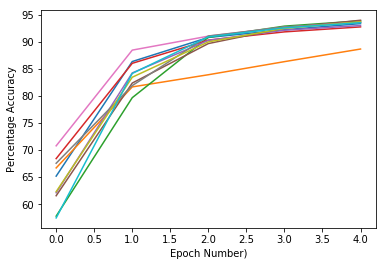

Epoch 0 - Training loss: 1.7194138765335083

Test set: Average loss: 1.5200, Accuracy: 6065/10000 (61%)

60.65

Test set: Average loss: 1.5944, Accuracy: 6879/10000 (69%)

68.79

Test set: Average loss: 1.5367, Accuracy: 6574/10000 (66%)

65.74

Test set: Average loss: 1.5545, Accuracy: 6283/10000 (63%)

62.83

Test set: Average loss: 1.5882, Accuracy: 6398/10000 (64%)

63.98

Test set: Average loss: 1.5886, Accuracy: 6040/10000 (60%)

60.4

Test set: Average loss: 1.4522, Accuracy: 6903/10000 (69%)

69.03

Test set: Average loss: 1.5381, Accuracy: 7095/10000 (71%)

70.95

Test set: Average loss: 1.5515, Accuracy: 6094/10000 (61%)

60.94

Test set: Average loss: 1.5420, Accuracy: 5382/10000 (54%)

53.82

Test set: Average loss: 1.5271, Accuracy: 6259/10000 (63%)

62.59

Test set: Average loss: 1.5635, Accuracy: 5702/10000 (57%)

57.02

Test set: Accuracy: 6915/10000 (69%)


Test set: Accuracy with Noise: 6803/10000 (68%)

Epoch 1 - Training loss: 0.8117891550064087

Test set: Average l

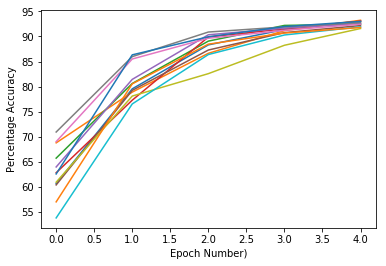

Epoch 0 - Training loss: 1.5143940448760986

Test set: Average loss: 1.8515, Accuracy: 5865/10000 (59%)

58.65

Test set: Average loss: 1.8073, Accuracy: 5525/10000 (55%)

55.25

Test set: Average loss: 1.8192, Accuracy: 5431/10000 (54%)

54.31

Test set: Average loss: 1.8661, Accuracy: 4560/10000 (46%)

45.6

Test set: Average loss: 1.8454, Accuracy: 5099/10000 (51%)

50.99

Test set: Average loss: 1.8224, Accuracy: 6172/10000 (62%)

61.72

Test set: Average loss: 1.8034, Accuracy: 5641/10000 (56%)

56.41

Test set: Average loss: 1.8616, Accuracy: 6856/10000 (69%)

68.56

Test set: Average loss: 1.7825, Accuracy: 5716/10000 (57%)

57.16

Test set: Average loss: 1.8751, Accuracy: 6162/10000 (62%)

61.62

Test set: Average loss: 1.8282, Accuracy: 4689/10000 (47%)

46.89

Test set: Average loss: 1.7651, Accuracy: 6018/10000 (60%)

60.18

Test set: Average loss: 1.8110, Accuracy: 6012/10000 (60%)

60.12

Test set: Average loss: 1.8490, Accuracy: 5001/10000 (50%)

50.01

Test set: Accuracy

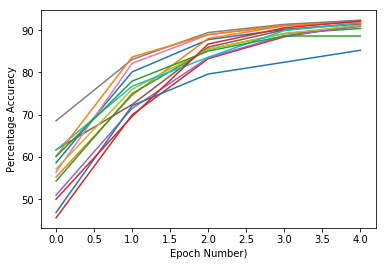

Epoch 0 - Training loss: 1.360765814781189

Test set: Average loss: 1.9560, Accuracy: 5534/10000 (55%)

55.34

Test set: Average loss: 1.9485, Accuracy: 5084/10000 (51%)

50.84

Test set: Average loss: 1.9523, Accuracy: 4879/10000 (49%)

48.79

Test set: Average loss: 1.9757, Accuracy: 4428/10000 (44%)

44.28

Test set: Average loss: 1.9717, Accuracy: 5224/10000 (52%)

52.24

Test set: Average loss: 1.9539, Accuracy: 5291/10000 (53%)

52.91

Test set: Average loss: 1.9534, Accuracy: 5787/10000 (58%)

57.87

Test set: Average loss: 1.9873, Accuracy: 4608/10000 (46%)

46.08

Test set: Average loss: 1.9421, Accuracy: 6322/10000 (63%)

63.22

Test set: Average loss: 1.9389, Accuracy: 5053/10000 (51%)

50.53

Test set: Average loss: 1.9611, Accuracy: 5956/10000 (60%)

59.56

Test set: Average loss: 1.9625, Accuracy: 6714/10000 (67%)

67.14

Test set: Average loss: 1.9664, Accuracy: 4432/10000 (44%)

44.32

Test set: Average loss: 1.9615, Accuracy: 5859/10000 (59%)

58.59

Test set: Average 

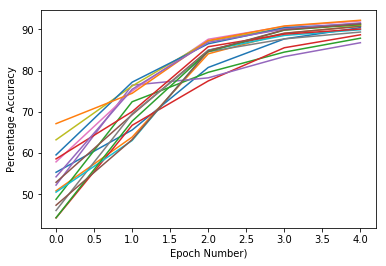

Epoch 0 - Training loss: 1.1974929571151733

Test set: Average loss: 2.0438, Accuracy: 5887/10000 (59%)

58.87

Test set: Average loss: 2.0444, Accuracy: 5361/10000 (54%)

53.61

Test set: Average loss: 2.0501, Accuracy: 4581/10000 (46%)

45.81

Test set: Average loss: 2.0411, Accuracy: 4868/10000 (49%)

48.68

Test set: Average loss: 2.0492, Accuracy: 5600/10000 (56%)

56.0

Test set: Average loss: 2.0638, Accuracy: 4379/10000 (44%)

43.79

Test set: Average loss: 2.0350, Accuracy: 4685/10000 (47%)

46.85

Test set: Average loss: 2.0540, Accuracy: 4786/10000 (48%)

47.86

Test set: Average loss: 2.0688, Accuracy: 5264/10000 (53%)

52.64

Test set: Average loss: 2.0648, Accuracy: 4370/10000 (44%)

43.7

Test set: Average loss: 2.0642, Accuracy: 4699/10000 (47%)

46.99

Test set: Average loss: 2.0394, Accuracy: 5221/10000 (52%)

52.21

Test set: Average loss: 2.0291, Accuracy: 4538/10000 (45%)

45.38

Test set: Average loss: 2.0713, Accuracy: 6195/10000 (62%)

61.95

Test set: Average l

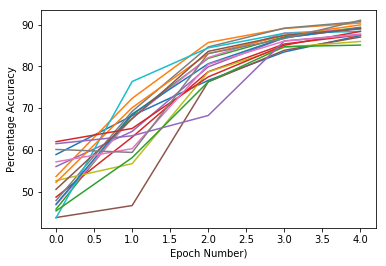

Epoch 0 - Training loss: 1.0725595951080322

Test set: Average loss: 2.1271, Accuracy: 3583/10000 (36%)

35.83

Test set: Average loss: 2.1132, Accuracy: 4819/10000 (48%)

48.19

Test set: Average loss: 2.1062, Accuracy: 5573/10000 (56%)

55.73

Test set: Average loss: 2.1126, Accuracy: 6235/10000 (62%)

62.35

Test set: Average loss: 2.1168, Accuracy: 4322/10000 (43%)

43.22

Test set: Average loss: 2.1020, Accuracy: 3639/10000 (36%)

36.39

Test set: Average loss: 2.1026, Accuracy: 3309/10000 (33%)

33.09

Test set: Average loss: 2.1096, Accuracy: 4223/10000 (42%)

42.23

Test set: Average loss: 2.1195, Accuracy: 5382/10000 (54%)

53.82

Test set: Average loss: 2.0985, Accuracy: 4765/10000 (48%)

47.65

Test set: Average loss: 2.1117, Accuracy: 4457/10000 (45%)

44.57

Test set: Average loss: 2.1133, Accuracy: 5022/10000 (50%)

50.22

Test set: Average loss: 2.0924, Accuracy: 4203/10000 (42%)

42.03

Test set: Average loss: 2.1067, Accuracy: 5756/10000 (58%)

57.56

Test set: Average

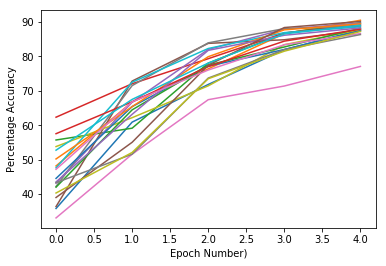

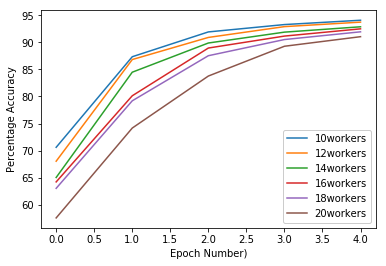

In [10]:
totalWorkers =[10, 12, 14, 16, 18, 20]
aggregateAccuracyDiffWorkers = np.empty((len(totalWorkers), args.epochs), dtype=float)
index = 0
aggregateAccuracy = np.empty((args.epochs), dtype = float)
for noWorkers in totalWorkers: # training and testing with different number of workers
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment
    models = []
    workers = connect_to_workers(hook, noWorkers)

    # Create optimisers for each model and link to them
    optimizers = [
        optim.SGD(model.parameters(), lr=0.03,)
        for model in models
    ]
    
    fedCollabNN = FedCollabNN(models, optimizers)
    
    # Distributing and sending the data and their corresponding labels to workers
    train_distributed_dataset = []

    n_max_batch = 500
    n_train_items = n_max_batch * args.batch_size

    for batch_idx, (data,target) in enumerate(train_loader):
        if batch_idx < n_max_batch:
            data = data.send(workers[batch_idx % len(workers)])
            target = target.send(workers[batch_idx % len(workers)])
            train_distributed_dataset.append((data, target))
    
    
    workerTestAccuracies = np.empty((args.epochs,len(workers)), dtype=float)
    
    
    for i in range(args.epochs): 
        imageTensor = []
        labelTensor = []
        running_loss = 0
        idx=0
        

        for images, labels in train_distributed_dataset:
            if (idx == len(workers)):# in every step a single batch for each workers is used to train models
                loss = train(imageTensor, labelTensor, fedCollabNN)
                running_loss += loss
                imageTensor = []
                labelTensor = []
                idx = 0

            imageTensor.append(images)
            labelTensor.append(labels)
            idx += 1

        else:
            print("Epoch {} - Training loss: {}".format(i, running_loss*10/len(train_distributed_dataset)))
        
        # testing each model accuracyy after each epoch
        finalModel = []
        testAccuracies = []
        for j in range(len(models)):
            finalModel= models[j].get()
            workerTestAccuracies[i,j] = test(args, finalModel, test_loader)
            print(workerTestAccuracies[i,j])
            finalModel.send(workers[j])
        
        # testing aggregated accuracyy after each epoch
        temp, aggregateAccuracy[i] = testAggregate(args, models, test_loader)
        for k in range(len(models)):
            models[k].send(workers[k])
    
    aggregateAccuracyDiffWorkers[index, :] =aggregateAccuracy
    index += 1
    ### Plot commands for model accuracies with different number of workers
    plt.figure()
    for worker in range(noWorkers):
        plt.plot(workerTestAccuracies[:,worker], label='worker '+ str(worker))
    plt.xlabel("Epoch Number)")
    plt.ylabel("Percentage Accuracy")
    #plt.legend(framealpha=1, frameon=True)
    plt.xticks(np.arange(1, 6, step=1))
    plt.savefig(str(noWorkers) + '_' + str(worker) + 'workerTestAccuracies.eps', format='eps')
    plt.show()
    

### Plot commands for aggregated accuracies with different number of workers
plt.figure()
index=0
for noWorkers in range(len(totalWorkers)):
    plt.plot(aggregateAccuracyDiffWorkers[noWorkers, :], label= str(totalWorkers[index]) + 'workers')
    index +=1
    
plt.xlabel("Epoch Number)")
plt.ylabel("Percentage Accuracy")   
plt.xticks(np.arange(1, 6, step=1))
plt.legend(framealpha=1, frameon=True)
plt.savefig('workerTestAggregateAccuracies.eps', format='eps')

In [11]:
workerTestAccuracies[0,:]

array([35.83, 48.19, 55.73, 62.35, 43.22, 36.39, 33.09, 42.23, 53.82,
       47.65, 44.57, 50.22, 42.03, 57.56, 43.53, 39.02, 47.21, 43.32,
       40.33, 52.77])

In [12]:
aggregateAccuracy

array([57.54, 74.16, 83.78, 89.29, 91.06])

In [13]:

aggregateAccuracy

array([57.54, 74.16, 83.78, 89.29, 91.06])

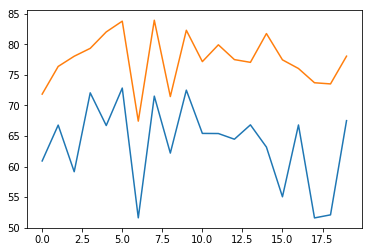

In [14]:
plt.plot(workerTestAccuracies[1,:])
plt.plot(workerTestAccuracies[2,:])
plt.savefig('destination_path.eps', format='eps')
plt.show()